In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import stft #stft
from scipy.signal import butter, sosfiltfilt #signal filtering 
from scipy.interpolate import interp1d
import numpy as npy
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
#first test example from "MuseCrocMobile" Paper recorded w/ v0.7
file_path = "2025-08-16_15_12_26_Muse_Recording.csv"

#while programming - moving around at desk App slow during v8.1 recording test before versioning fix. 
#file_path = "MuseCrocMobile_2025-10-08_21_57_05_MS_03PRESET_1032_EEG@256Hz_Accelerometer@52Hz_Gyroscope@52Hz_DRL_REF@32Hz_Optics@64Hz_.csv"

#eyes open, staring at monitor. App slow during v8.1 recording test before versioning fix. 
#file_path = "MuseCrocMobile_2025-10-08_21_12_24_MS_03PRESET_1032_EEG@256Hz_Accelerometer@52Hz_Gyroscope@52Hz_DRL_REF@32Hz_Optics@64Hz_.csv"

#Fixation test w/ v8.2 testing
#file_path = "MuseCrocMobile_2025-10-09_21_52_56_MS_03PRESET_1032_EEG@256Hz_Accelerometer@52Hz_Gyroscope@52Hz_DRL_REF@32Hz_Optics@64Hz_.csv"

#fixation test in car - Test 1, less noise in theory
#file_path = "MuseCrocMobile_2025-10-09_22_56_43_MS_03PRESET_1032_EEG@256Hz_Accelerometer@52Hz_Gyroscope@52Hz_DRL_REF@32Hz_Optics@64Hz_.csv"

#fixation test in car - Test 2, less noise in theory
file_path = "MuseCrocMobile_2025-10-09_22_58_46_MS_03PRESET_1032_EEG@256Hz_Accelerometer@52Hz_Gyroscope@52Hz_DRL_REF@32Hz_Optics@64Hz_.csv"


#change to your file path
df = pd.read_csv(file_path)
df.head()

for col_name in df.columns:
    print(col_name)

print(df.shape)

#prints packet types
print(df['PACKET_TYPE'].unique())

#Setting font size to 25 for all graphs
plt.rcParams.update({'font.size': 25})

PACKET_TYPE
CLOCK_TIME
ms_ELAPSED
TP9_CONNECTION_STRENGTH(HSI)
TP9_ARTIFACT_FREE(IS_GOOD)
AF7_CONNECTION_STRENGTH(HSI)
AF7_ARTIFACT_FREE(IS_GOOD)
AF8_CONNECTION_STRENGTH(HSI)
AF8_ARTIFACT_FREE(IS_GOOD)
TP10_CONNECTION_STRENGTH(HSI)
TP10_ARTIFACT_FREE(IS_GOOD)
TP9_RAW
AF7_RAW
AF8_RAW
TP10_RAW
DRL
REF
TP9_DELTA_ABSOLUTE
AF7_DELTA_ABSOLUTE
AF8_DELTA_ABSOLUTE
TP10_DELTA_ABSOLUTE
TP9_THETA_ABSOLUTE
AF7_THETA_ABSOLUTE
AF8_THETA_ABSOLUTE
TP10_THETA_ABSOLUTE
TP9_ALPHA_ABSOLUTE
AF7_ALPHA_ABSOLUTE
AF8_ALPHA_ABSOLUTE
TP10_ALPHA_ABSOLUTE
TP9_BETA_ABSOLUTE
AF7_BETA_ABSOLUTE
AF8_BETA_ABSOLUTE
TP10_BETA_ABSOLUTE
TP9_GAMMA_ABSOLUTE
AF7_GAMMA_ABSOLUTE
AF8_GAMMA_ABSOLUTE
TP10_GAMMA_ABSOLUTE
TP9_DELTA_RELATIVE
AF7_DELTA_RELATIVE
AF8_DELTA_RELATIVE
TP10_DELTA_RELATIVE
TP9_THETA_RELATIVE
AF7_THETA_RELATIVE
AF8_THETA_RELATIVE
TP10_THETA_RELATIVE
TP9_ALPHA_RELATIVE
AF7_ALPHA_RELATIVE
AF8_ALPHA_RELATIVE
TP10_ALPHA_RELATIVE
TP9_BETA_RELATIVE
AF7_BETA_RELATIVE
AF8_BETA_RELATIVE
TP10_BETA_RELATIVE
TP9_GAMMA_RELA

Original dataframe shape: (79743, 80)
Optics-only dataframe shape: (8927, 18)

Total Recording time in ms: 139101
Total Recording time in s: 139.101
Number of samples: 8927

Expected number of samples (ms precision): 8902.464

Write Timing Stats: 

count    8926.000000
mean       15.575510
std        31.655149
min         0.000000
25%         1.000000
50%         1.000000
75%        21.000000
max       426.000000
Name: ms_diff, dtype: float64


Expected Mean ms Between Writes: 15.625

Actual Mean ms between: 15.57550974680708
Max ms between: 426.0


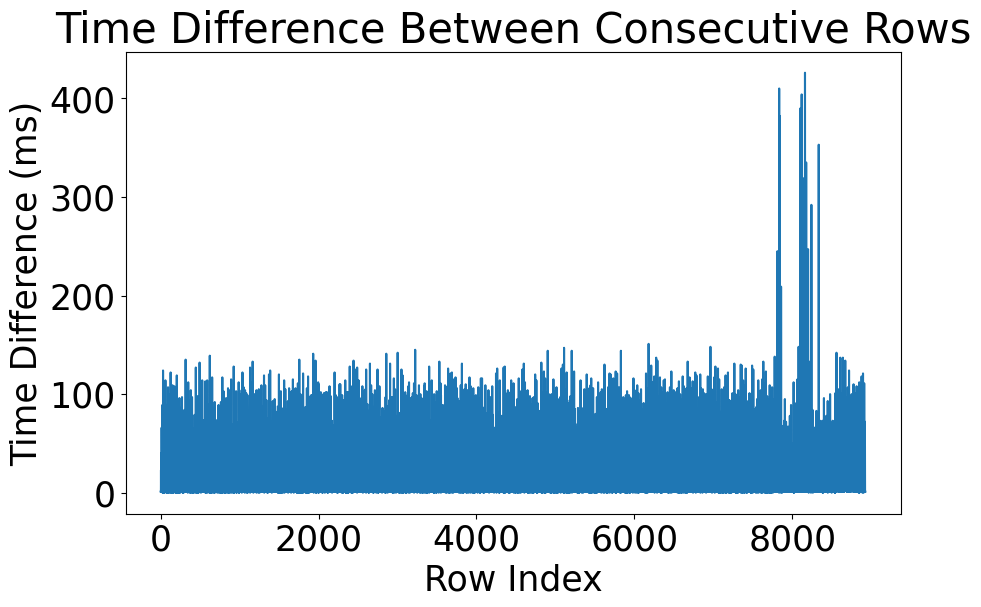

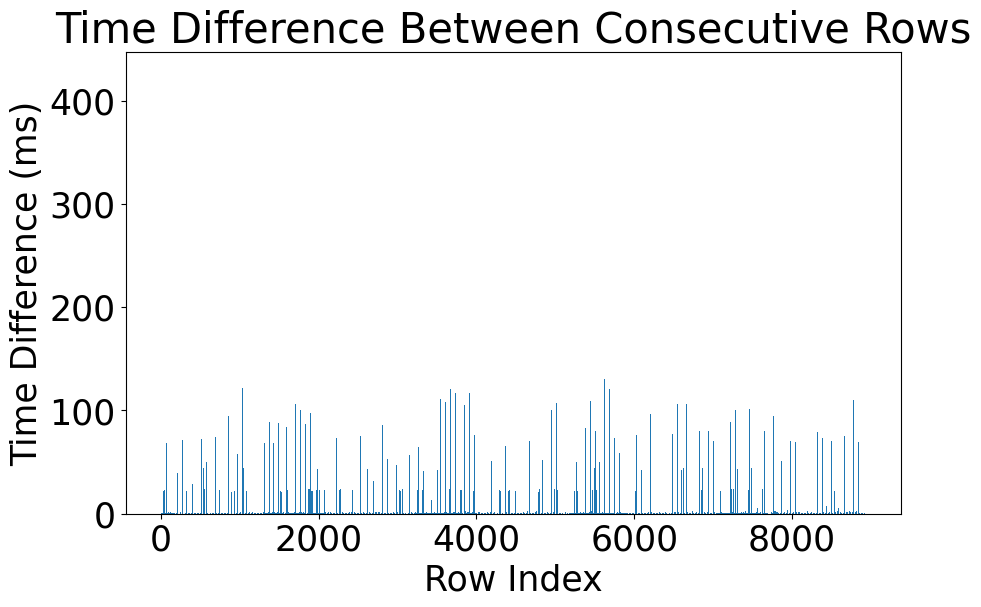

In [3]:
'''
Now, for accurate processing of raw OPTICS, 
we need to select values only from lines 
where packet type is OPTICS. This is to 
remove duplicate values and prevent / spot 
possible issues. 
'''

# Filter for raw OTPICS packet types only
optics_df = df[df['PACKET_TYPE'] == 'OPTICS'][['ms_ELAPSED',
'730nm_LEFT_OUTER',
'730nm_RIGHT_OUTER',
'850nm_LEFT_OUTER',
'850nm_RIGHT_OUTER',
'730nm_LEFT_INNER',
'730nm_RIGHT_INNER',
'850nm_LEFT_INNER',
'850nm_RIGHT_INNER',
'RED_LEFT_OUTER',
'RED_RIGHT_OUTER',
'AMBIENT_LEFT_OUTER',
'AMBIENT_RIGHT_OUTER',
'RED_LEFT_INNER',
'RED_RIGHT_INNER',
'AMBIENT_LEFT_INNER',
'AMBIENT_RIGHT_INNER']].copy()


#get time in seconds of optics recording
optics_df_time_sec = optics_df["ms_ELAPSED"] / 1000.0

# Reset index for clean indexing
optics_df = optics_df.reset_index(drop=True)

#file sampling rate: 
fs = 64
recording_time_sec = optics_df_time_sec.max()
recording_time_ms = optics_df["ms_ELAPSED"].max()

#expected number of samples
expected_sample_no = (fs/1000) * recording_time_ms

#expected time between writes
expected_interWrite_ms = 1000/fs

optics_df.head()

''' 
checking distance between packets to identify recording issues.

Please note that packets are generated by the Muse device at 64Hz, 
and this code is meant to evaluate application performance & 
write patterns. 

Packets are written to file at an uneven rate by the recieving 
device, and so recording stalls do not always mean missed 
data. 
'''

# Calculate the difference between consecutive rows
optics_df['ms_diff'] = optics_df['ms_ELAPSED'].diff()


#Printing text representig our data characteristics 
print(f"Original dataframe shape: {df.shape}")
print(f"Optics-only dataframe shape: {optics_df.shape}\n")

print(f"Total Recording time in ms: {recording_time_ms}")
print(f"Total Recording time in s: {recording_time_sec}")
print(f"Number of samples: {len(optics_df)}\n")

print(f"Expected number of samples (ms precision): {expected_sample_no}\n")

#write stats 
print(f"Write Timing Stats: \n")
print(optics_df['ms_diff'].describe())
print(f"\n")
#distance between writes based on fs
print(f"Expected Mean ms Between Writes: {expected_interWrite_ms}\n")
print(f"Actual Mean ms between: {optics_df['ms_diff'].mean()}")
print(f"Max ms between: {optics_df['ms_diff'].max()}")

# plot the differences 
plt.figure(figsize=(10, 6))
plt.plot(optics_df.index, optics_df['ms_diff'])
plt.xlabel('Row Index')
plt.ylabel('Time Difference (ms)')
plt.title('Time Difference Between Consecutive Rows')
plt.show()

# plot the differences as a bar chart
plt.figure(figsize=(10, 6))
plt.bar(optics_df.index, optics_df['ms_diff'])
plt.xlabel('Row Index')
plt.ylabel('Time Difference (ms)')
plt.title('Time Difference Between Consecutive Rows')
plt.show()


/tmp/ipykernel_33951/2726544632.py:31: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


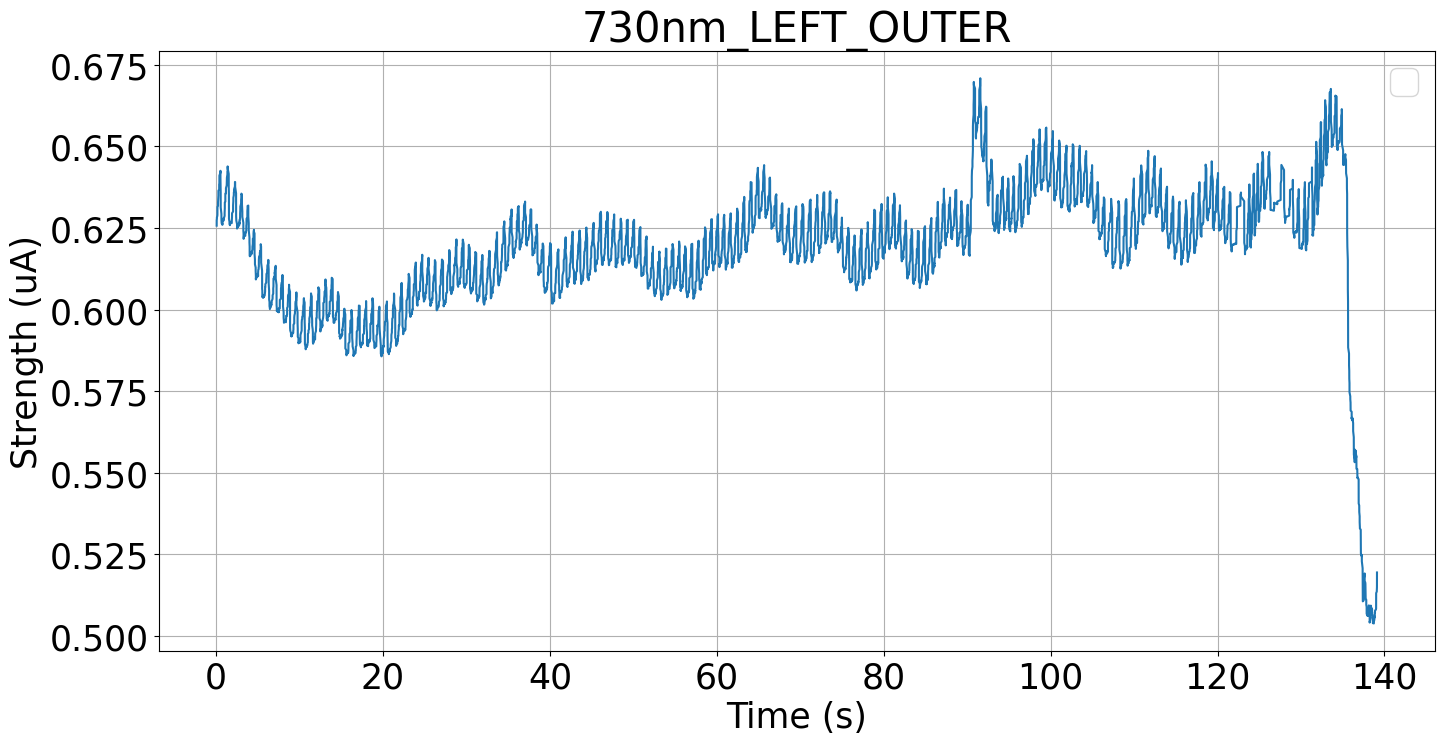

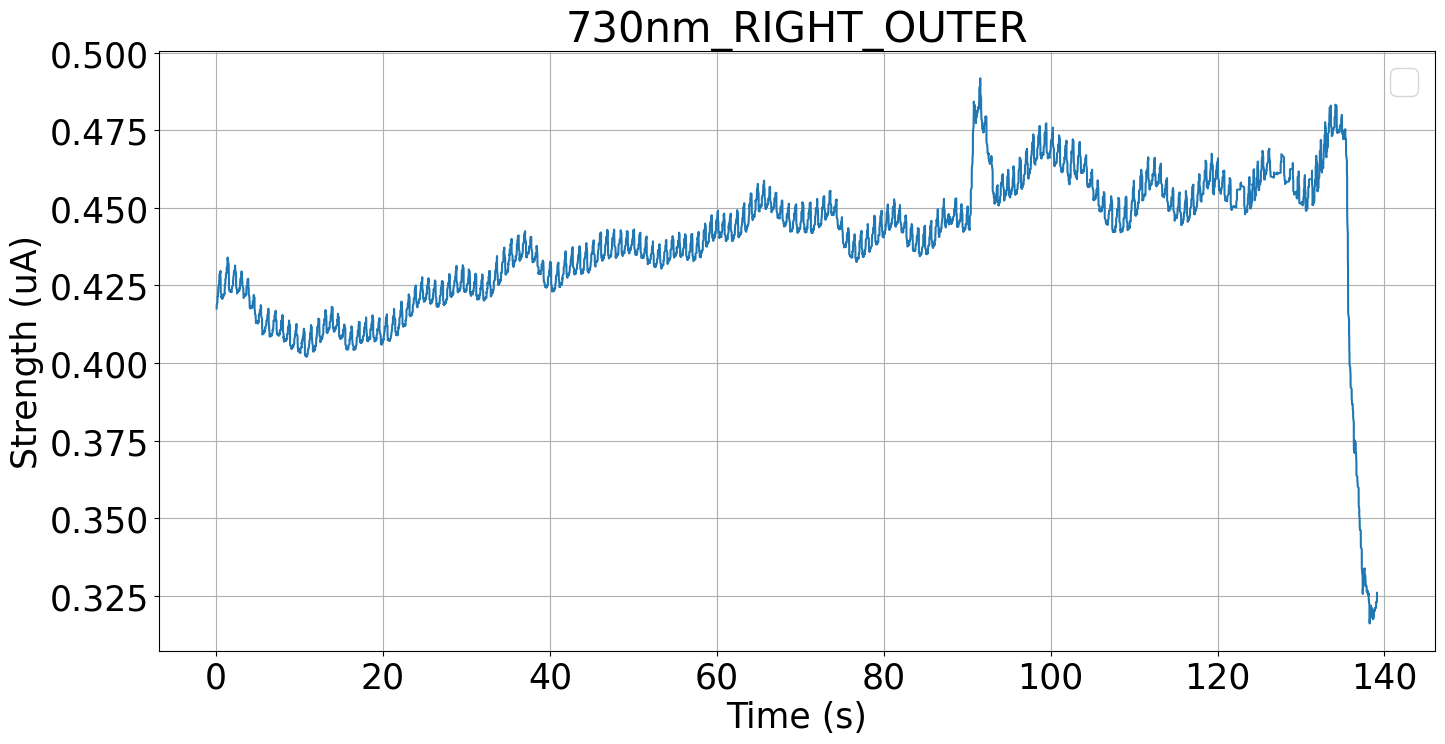

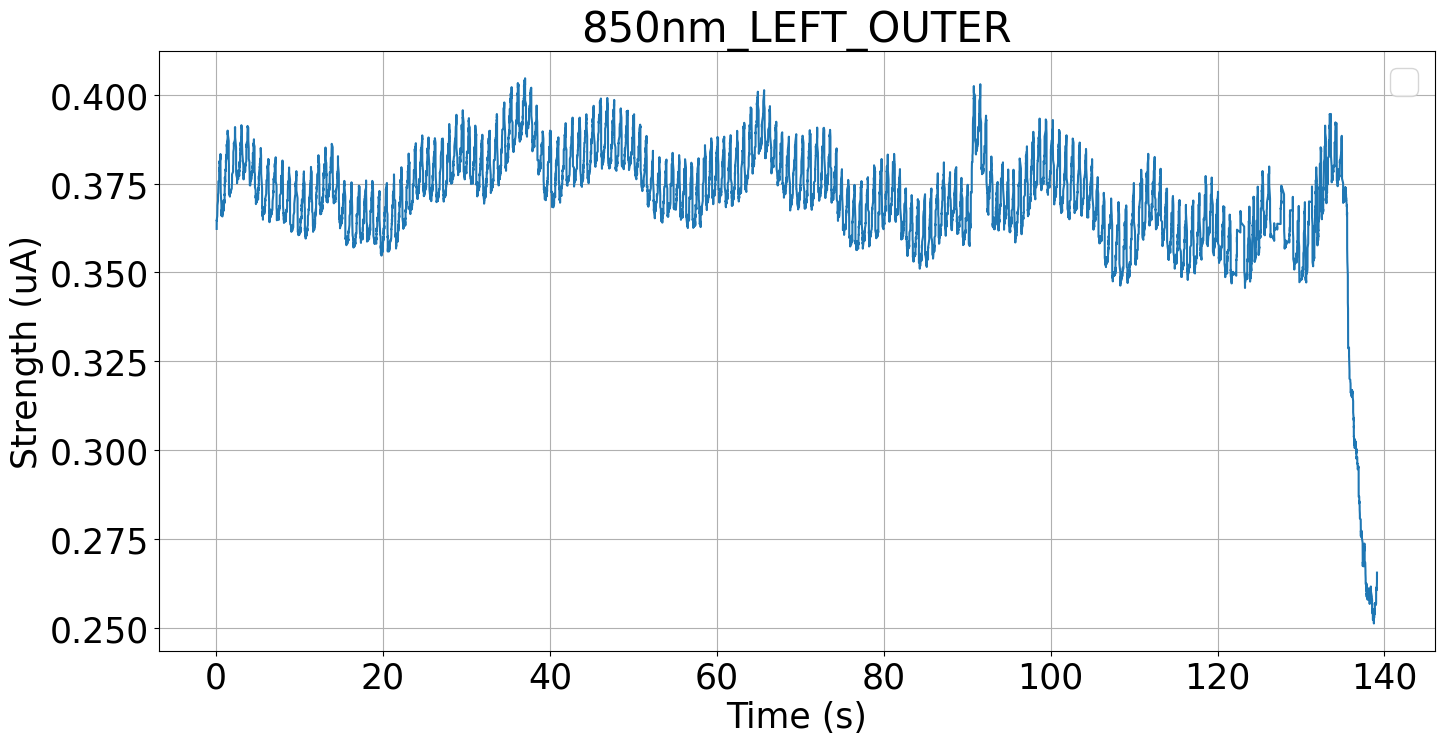

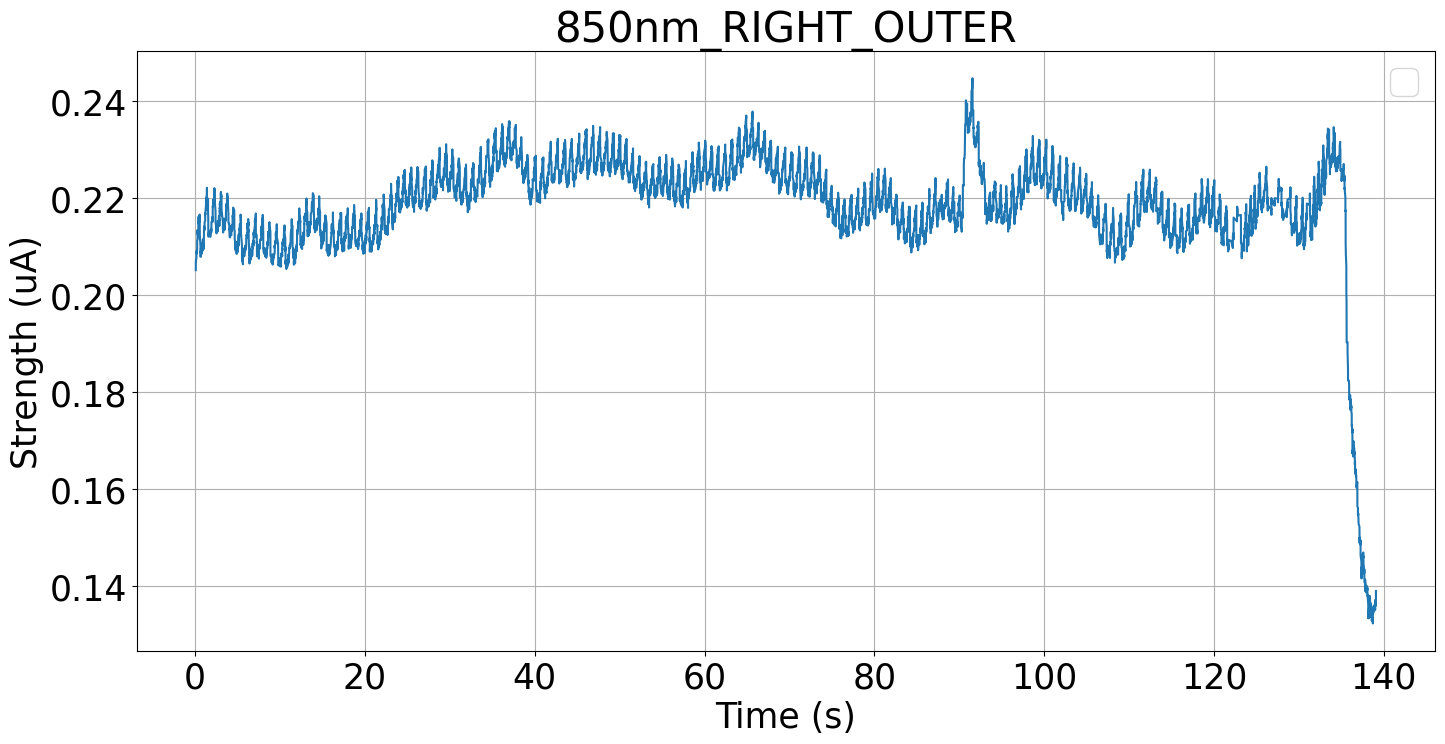

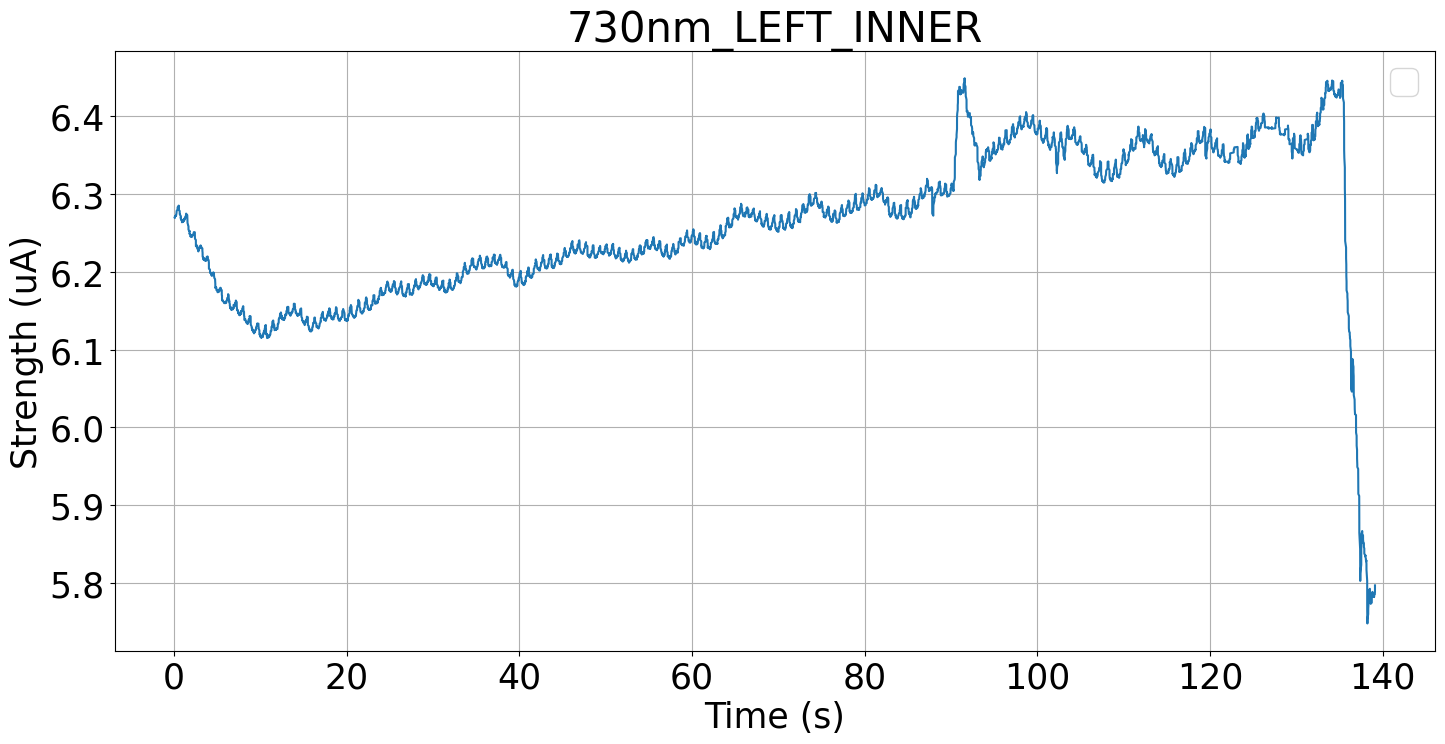

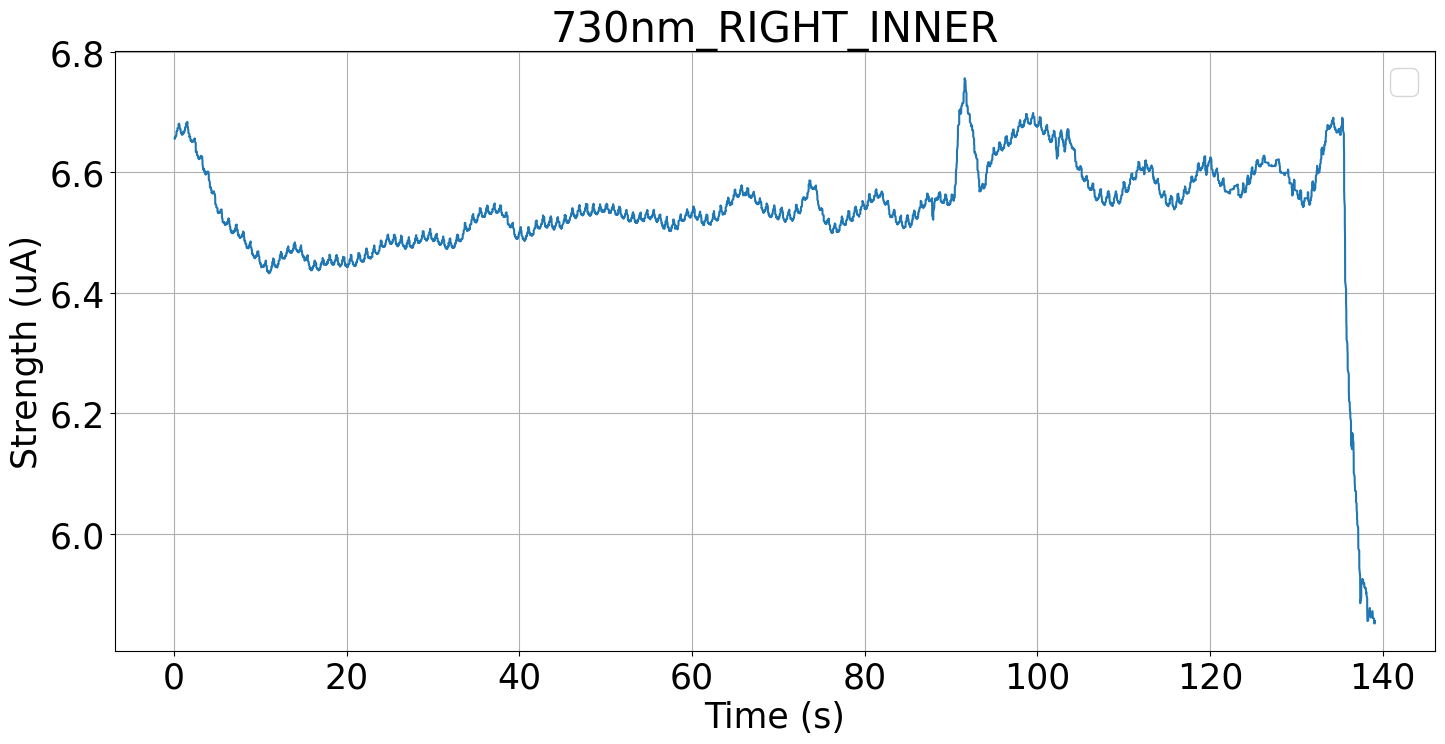

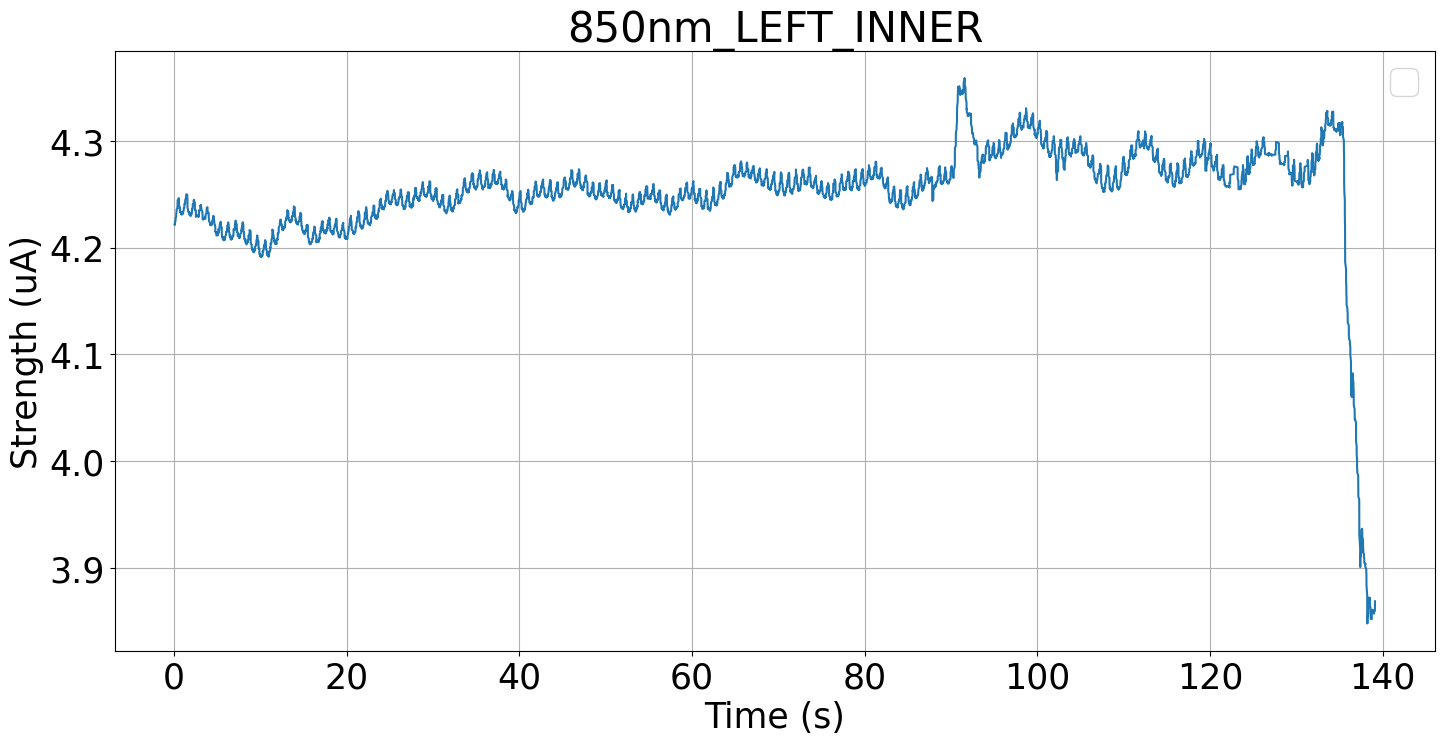

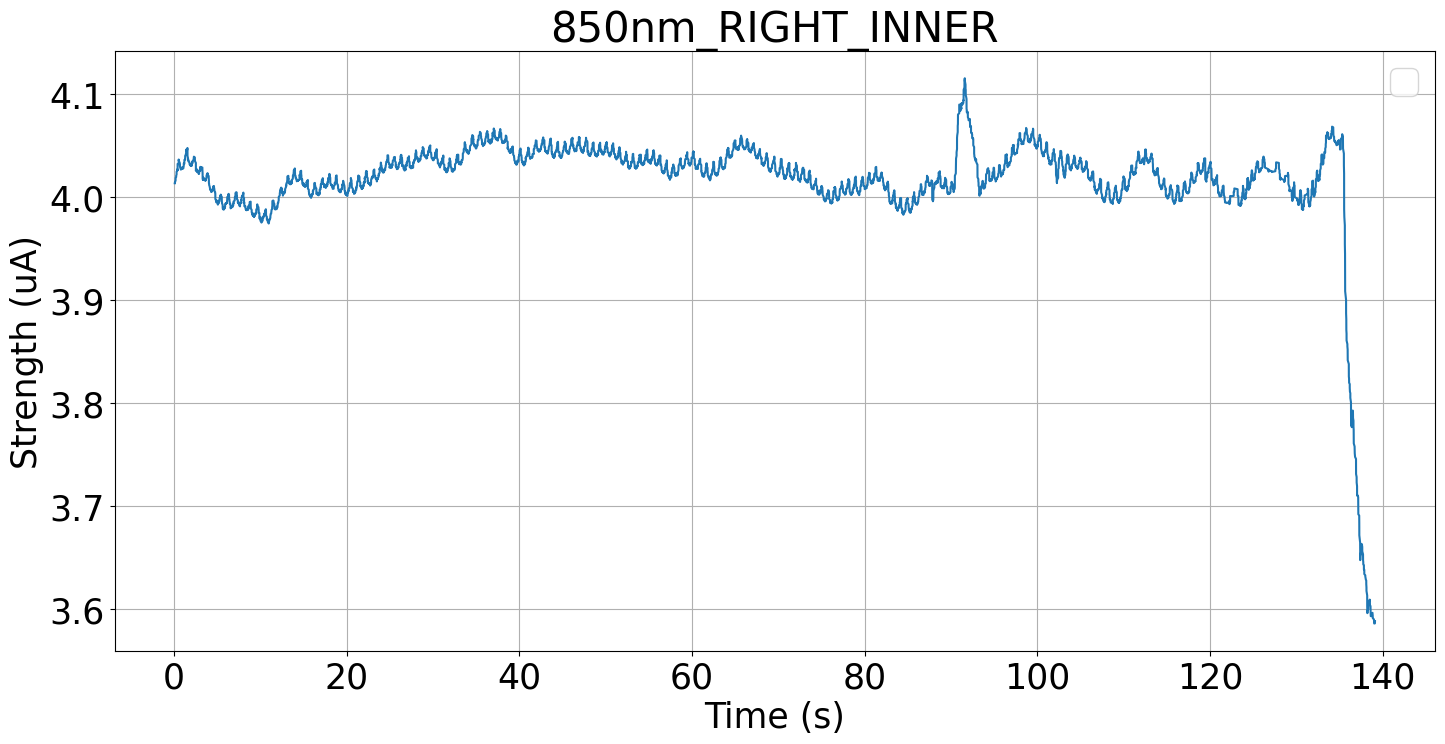

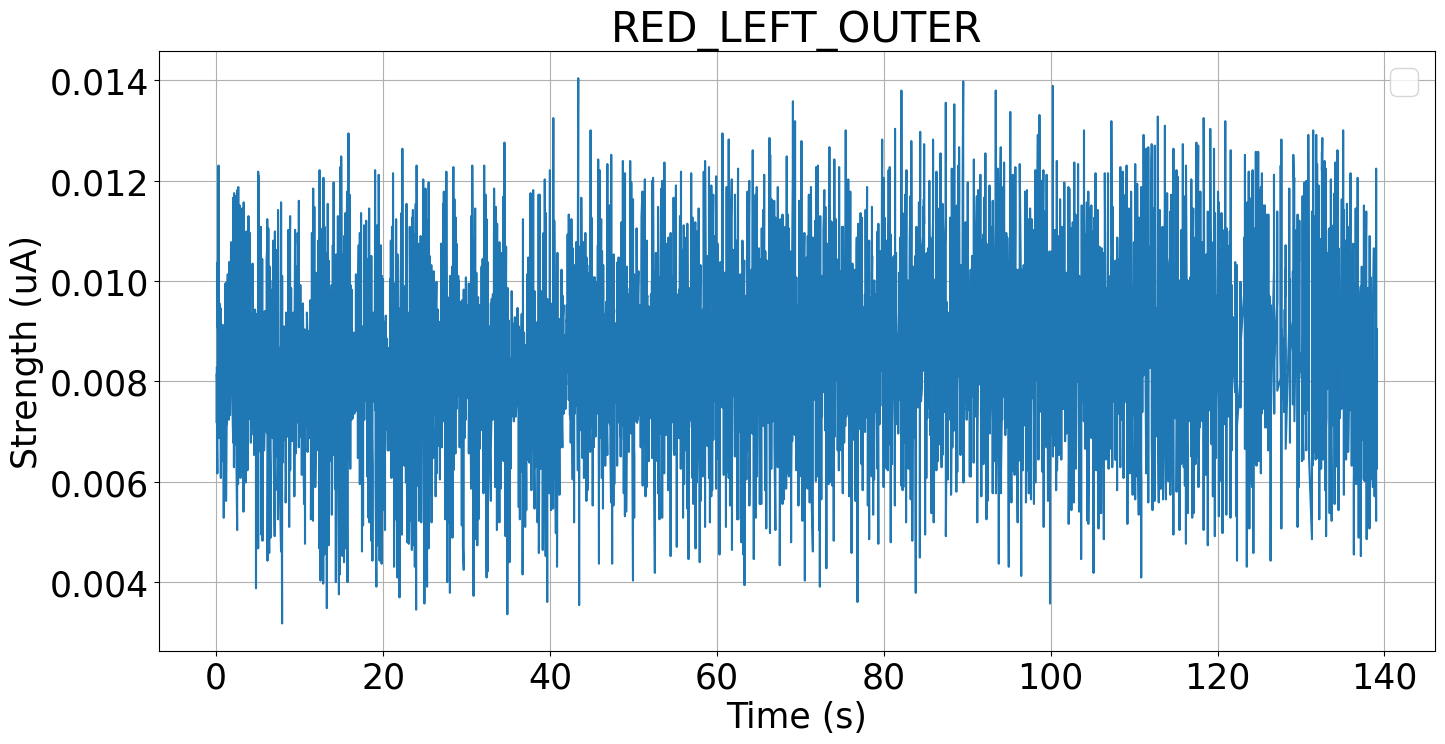

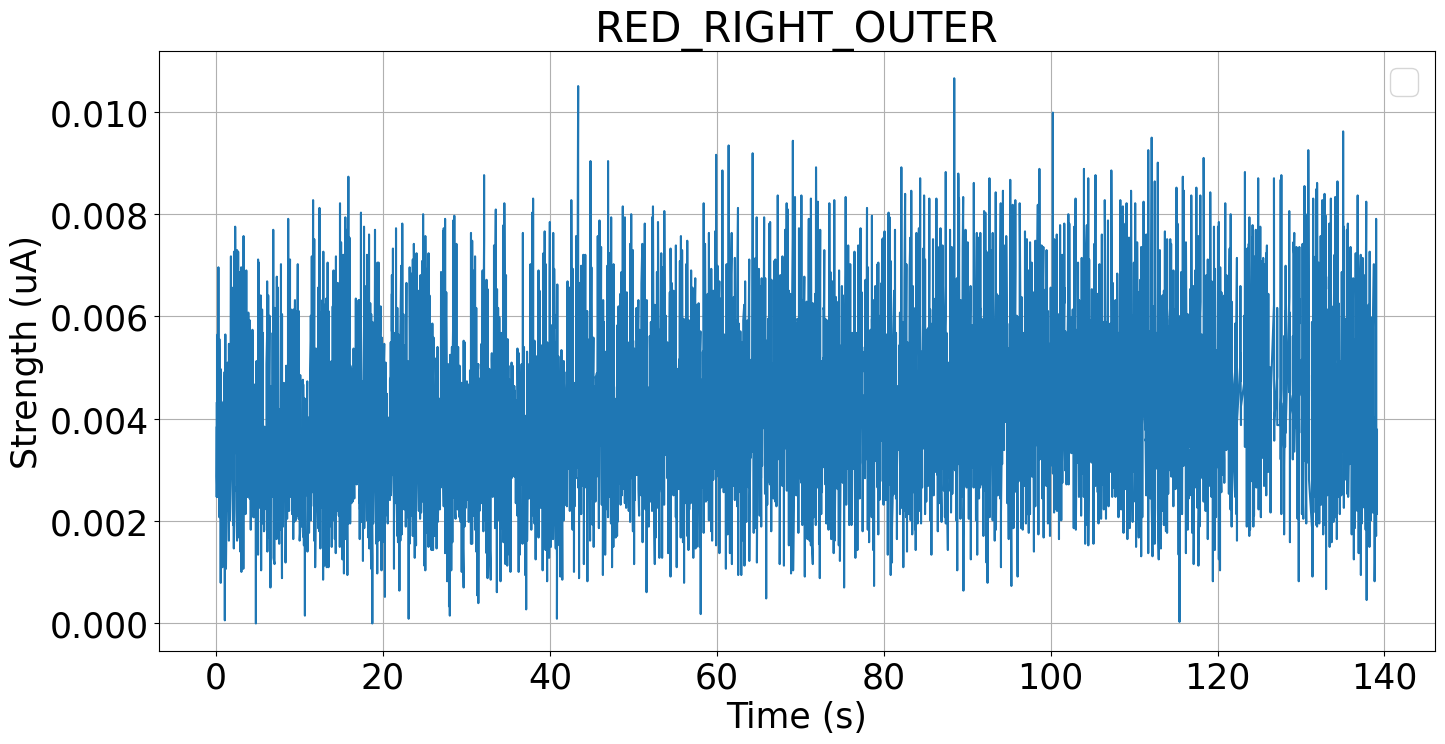

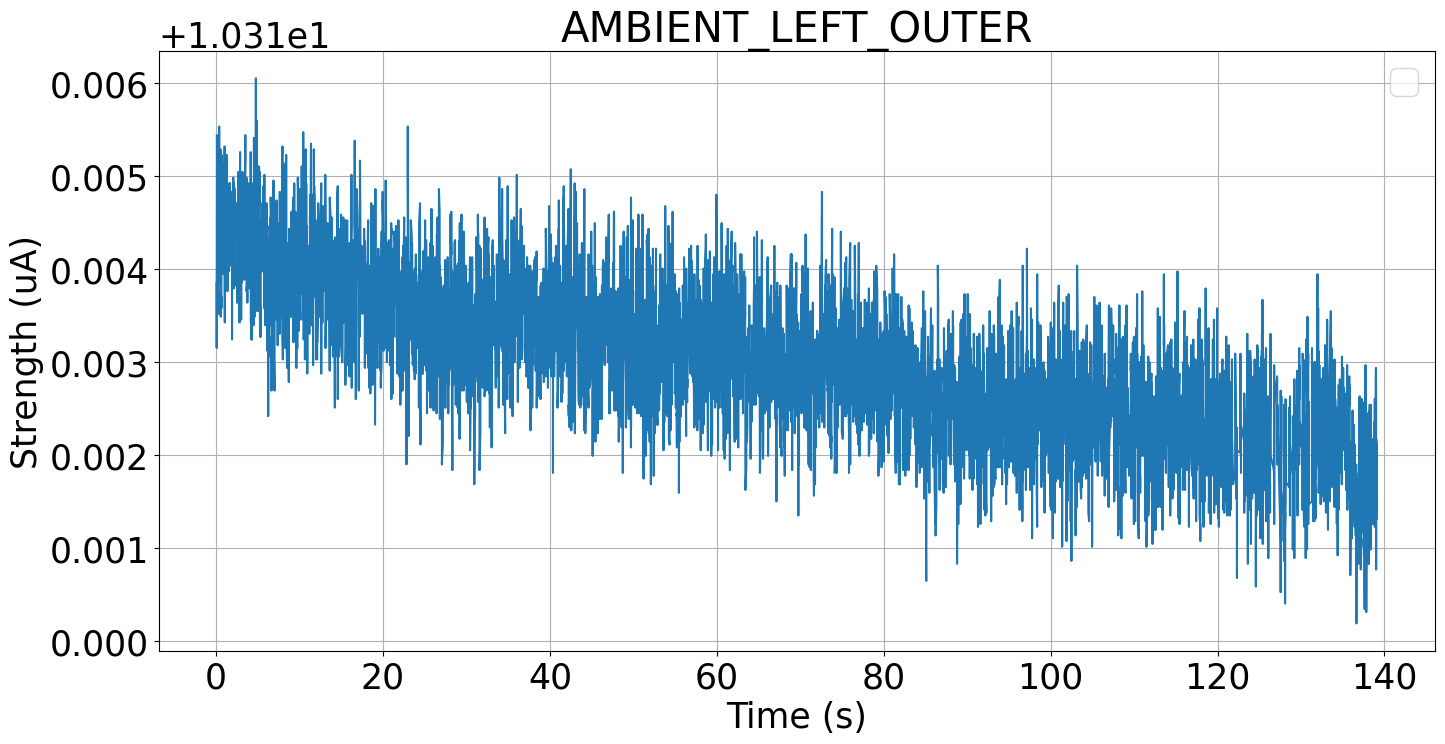

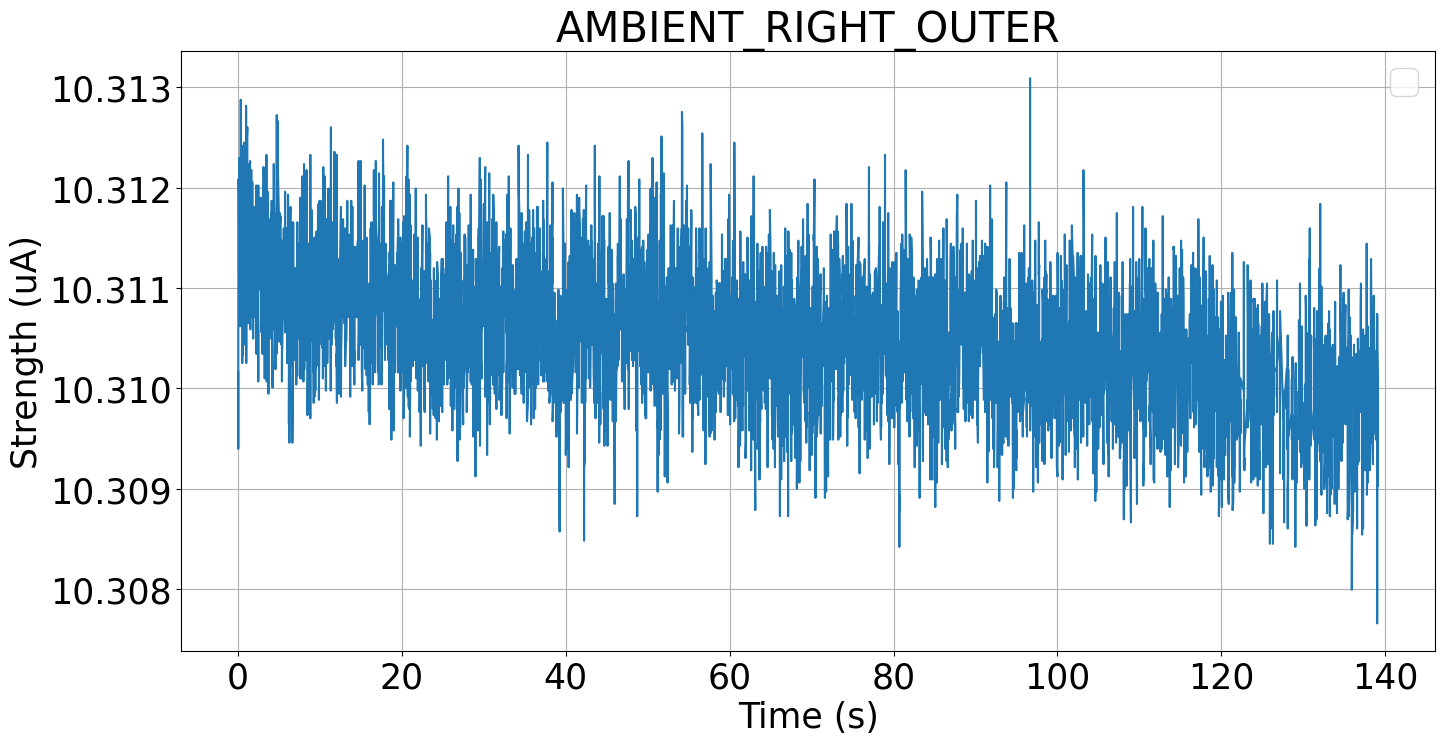

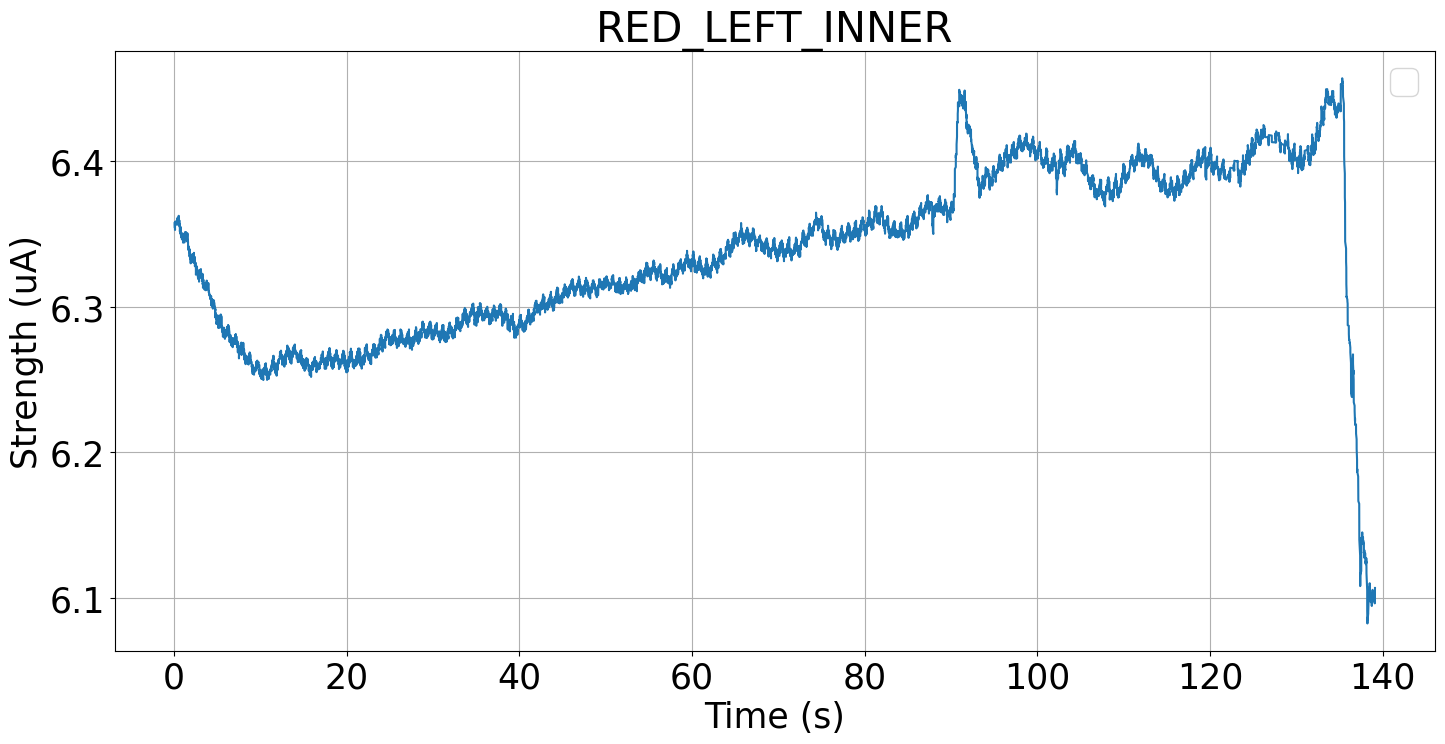

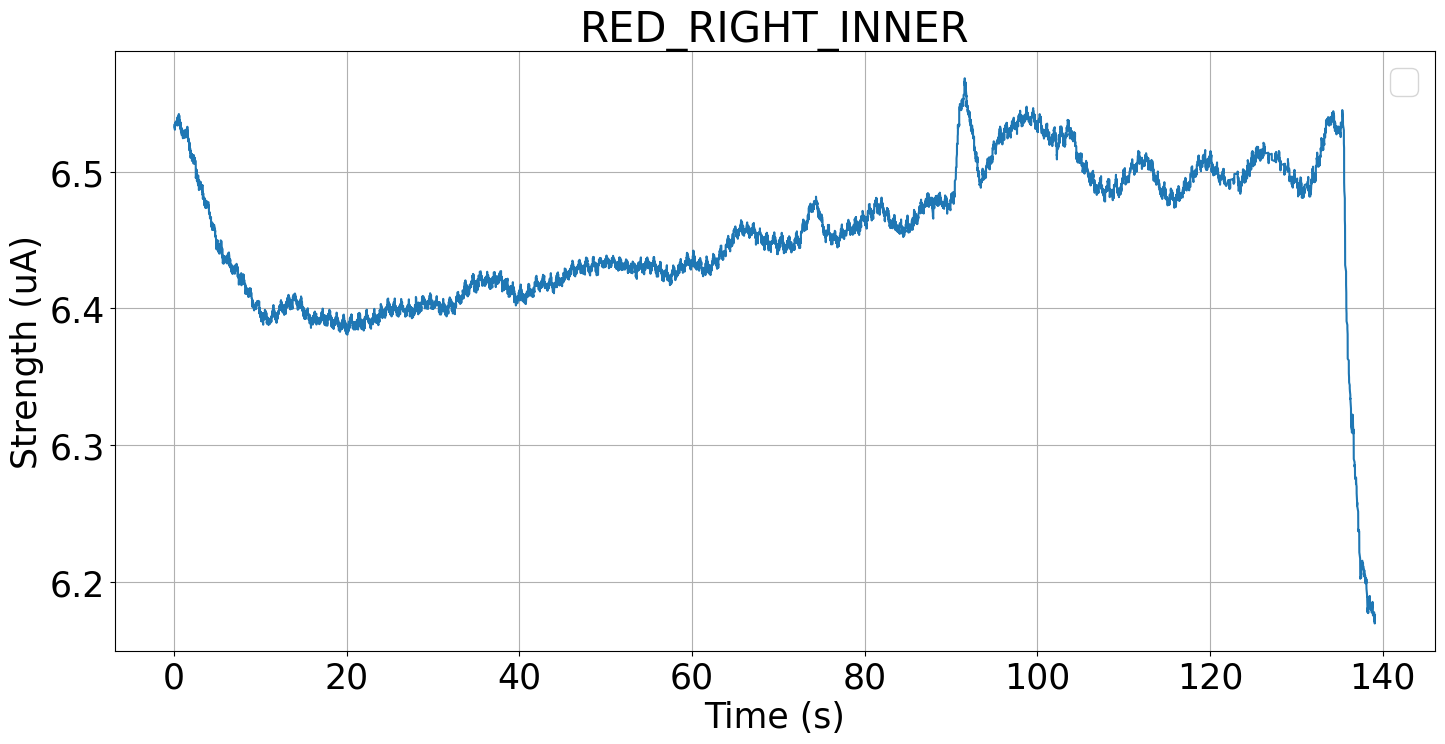

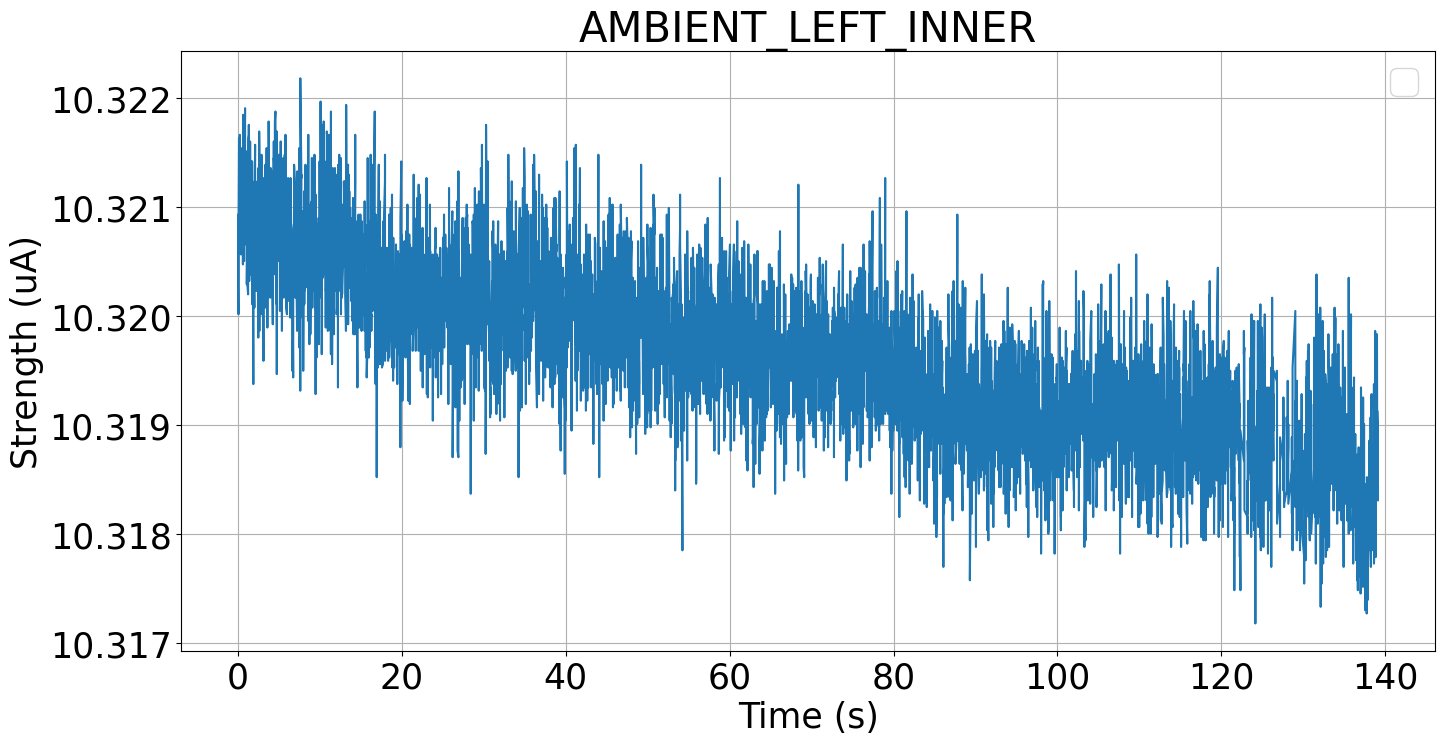

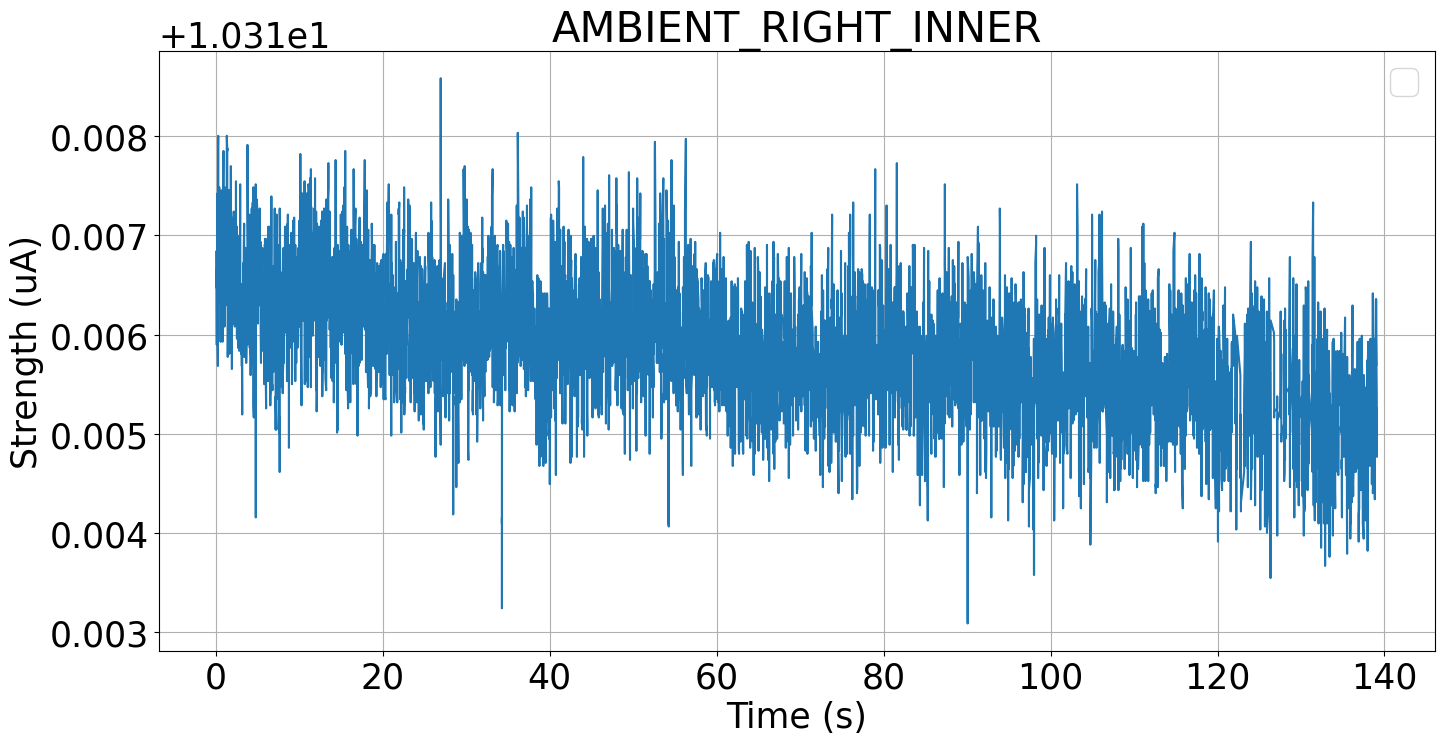

In [4]:
''' 
Graphing raw Athena fNIRS 
'''

channels = ['730nm_LEFT_OUTER',
'730nm_RIGHT_OUTER',
'850nm_LEFT_OUTER',
'850nm_RIGHT_OUTER',
'730nm_LEFT_INNER',
'730nm_RIGHT_INNER',
'850nm_LEFT_INNER',
'850nm_RIGHT_INNER',
'RED_LEFT_OUTER',
'RED_RIGHT_OUTER',
'AMBIENT_LEFT_OUTER',
'AMBIENT_RIGHT_OUTER',
'RED_LEFT_INNER',
'RED_RIGHT_INNER',
'AMBIENT_LEFT_INNER',
'AMBIENT_RIGHT_INNER']

for ch in channels:

    plt.figure(figsize=(15, 8))
    plt.plot(optics_df_time_sec, optics_df[ch])
    plt.title(ch)
    plt.xlabel("Time (s)")
    plt.ylabel("Strength (uA)")
    #plt.xlim(0,30)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()